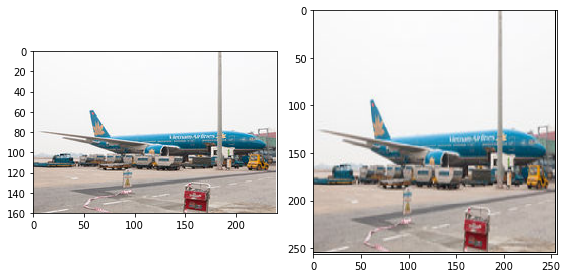

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

def bilinear_interpolation_naive(src, dst_size):
    """
    双线性差值的naive实现
    :param src: 源图像
    :param dst_size: 目标图像大小H*W
    :return: 双线性差值后的图像
    """
    (src_h, src_w, src_c) = src.shape  # 原图像大小 H*W*C
    (dst_h, dst_w), dst_c = dst_size, src_c  # 目标图像大小H*W*C

    if src_h == dst_h and src_w == dst_w:  # 如果大小不变，直接返回copy
        return src.copy()

    scale_h = float(src_h) / dst_h  # 计算H方向缩放比
    scale_w = float(src_w) / dst_w  # 计算W方向缩放比
    dst = np.zeros((dst_h, dst_w, dst_c), dtype=src.dtype)  # 目标图像初始化
    for h_d, row in enumerate(dst):  # 遍历目标图像H方向
        for w_d, col in enumerate(row):  # 遍历目标图像所有W方向
            h = scale_h * (h_d + 0.5) - 0.5  # 将目标图像H坐标映射到源图像上
            w = scale_w * (w_d + 0.5) - 0.5  # 将目标图像W坐标映射到源图像上
            h0 = int(np.floor(h))  # 最近4个点坐标h0
            w0 = int(np.floor(w))  # 最近4个点坐标w0
            h1 = min(h0 + 1, src_h - 1)  # h0 + 1就是h1，但是不能越界
            w1 = min(w0 + 1, src_w - 1)  # w0 + 1就是w1，但是不能越界
            r0 = (w1 - w) * src[h0, w0, ...] + (w - w0) * src[h0, w1, ...]  # 双线性差值R0
            r1 = (w1 - w) * src[h1, w0, ...] + (w - w0) * src[h1, w1, ...]  # 双线性插值R1
            p = (h1 - h) * r0 + (h - h0) * r1  # 双线性插值P
            dst[h_d, w_d, ...] = p.astype(np.uint8) # 插值结果放进目标像素点
    return dst


if __name__ == '__main__':
    def unit_test():
        image_file = os.path.join(os.getcwd(), 'test.jpg')
        image = mpimg.imread(image_file)
        image_scale = bilinear_interpolation_naive(image, (256, 256))
    
        fig, axes = plt.subplots(1, 2, figsize=(8, 10))
        axes = axes.flatten()
        axes[0].imshow(image)
        axes[1].imshow(image_scale)
        axes[0].axis([0, image.shape[1], image.shape[0], 0])
        axes[1].axis([0, image_scale.shape[1], image_scale.shape[0], 0])
        fig.tight_layout()
        plt.show()
        pass
        
    unit_test()



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import torch
import torch.nn.functional as F

def bilinear_interpolation(src, dst_size):
    """
    双线性插值高效实现
    :param src: 源图像H*W*C
    :param dst_size: 目标图像大小H*W*C
    :return: 双线性插值后的图像
    """
    (src_h, src_w, src_c) = src.shape  # 原图像大小 H*W*C
    (dst_h, dst_w), dst_c = dst_size, src_c  # 目标图像大小H*W*C

    if src_h == dst_h and src_w == dst_w:  # 如果大小不变，直接返回copy
        return src.copy()
    # 矩阵方式实现
    h_d = np.arange(dst_h)  # 目标图像H方向坐标
    w_d = np.arange(dst_w)  # 目标图像W方向坐标
    h = float(src_h) / dst_h * (h_d + 0.5) - 0.5  # 将目标图像H坐标映射到源图像上
    w = float(src_w) / dst_w * (w_d + 0.5) - 0.5  # 将目标图像W坐标映射到源图像上

    h = np.clip(h, 0, src_h - 1) # 防止越界，最上一行映射后是负数，置为0
    w = np.clip(w, 0, src_w - 1) # 防止越界，最左一行映射后是负数，置为0

    h = np.repeat(h.reshape(dst_h, 1), dst_w, axis=1)  # 同一行映射的h值都相等
    w = np.repeat(w.reshape(dst_w, 1), dst_h, axis=1).T  # 同一列映射的w值都相等

    h0 = np.floor(h).astype(np.int)  # 同一行的h0值都相等
    w0 = np.floor(w).astype(np.int)  # 同一列的w0值都相等

    h0 = np.clip(h0, 0, src_h - 2)  # 最下一行上不大于src_h - 2，相当于padding
    w0 = np.clip(w0, 0, src_w - 2)  # 最右一列左不大于src_w - 2，相当于padding

    h1 = np.clip(h0 + 1, 0, src_h - 1)  # 同一行的h1值都相等，防止越界
    w1 = np.clip(w0 + 1, 0, src_w - 1)  # 同一列的w1值都相等，防止越界

    q00 = src[h0, w0]  # 取每一个像素对应的q00
    q01 = src[h0, w1]  # 取每一个像素对应的q01
    q10 = src[h1, w0]  # 取每一个像素对应的q10
    q11 = src[h1, w1]  # 取每一个像素对应的q11

    h = np.repeat(h[..., np.newaxis], dst_c, axis=2)  # 图像有通道C，所有的计算都增加通道C
    w = np.repeat(w[..., np.newaxis], dst_c, axis=2)
    h0 = np.repeat(h0[..., np.newaxis], dst_c, axis=2)
    w0 = np.repeat(w0[..., np.newaxis], dst_c, axis=2)
    h1 = np.repeat(h1[..., np.newaxis], dst_c, axis=2)
    w1 = np.repeat(w1[..., np.newaxis], dst_c, axis=2)

    r0 = (w1 - w) * q00 + (w - w0) * q01  # 双线性插值的r0
    r1 = (w1 - w) * q10 + (w - w0) * q11  # 双线性差值的r1
    q = (h1 - h) * r0 + (h - h0) * r1  # 双线性差值的q
    dst = q.astype(src.dtype)  # 图像的数据类型
    return dst


if __name__ == "__main__":
    def unit_test2():
        image_file = os.path.join(os.getcwd(), 'test.jpg')
        image = mpimg.imread(image_file)
        image_scale = bilinear_interpolation(image, (256, 256))

        fig, axes = plt.subplots(1, 2, figsize=(8, 10))
        axes = axes.flatten()
        axes[0].imshow(image)
        axes[1].imshow(image_scale)
        axes[0].axis([0, image.shape[1], image.shape[0], 0])
        axes[1].axis([0, image_scale.shape[1], image_scale.shape[0], 0])
        fig.tight_layout()
        plt.show()
        pass
    unit_test2()

    def unit_test3():
        src = np.array([[1, 2], [3, 4]])
        print(src)
        src = src.reshape((2, 2, 1))
        dst_size = (4, 4)
        dst = bilinear_interpolation(src, dst_size)
        dst = dst.reshape(dst_size)
        print(dst)

        tsrc = torch.arange(1, 5, dtype=torch.float32).view(1, 1, 2, 2)
        print(tsrc)
        tdst = F.interpolate(
            tsrc,
            size=(4, 4),
            mode='bilinear'
        )
        print(tdst)
    # unit_test3()




